In [ ]:
import torch
import os
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
import multiprocessing as mp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import io, transforms
from torch.utils.data import Dataset, DataLoader, random_split

from transformers import (
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    VisionEncoderDecoderModel,
    ViTImageProcessor,
    AutoTokenizer,
    GPT2Config,
    default_data_collator
)

from evaluate import load
# Rouge metriği yükleme
rouge_metric = load("rouge")

# Wandb'yi devre dışı bırak (isteğe bağlı)
os.environ["WANDB_DISABLED"] = "true"


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Konfigürasyon sınıfı
class Config:
    encoder = "google/vit-base-patch16-224"
    decoder = "gpt2"
    train_batch_size = 16
    val_batch_size = 16
    val_epochs = 1
    lr = 2e-5
    seed = 42
    max_len = 128
    weight_decay = 0.02
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    train_pct = 0.8
    num_workers = mp.cpu_count()
    epochs = 10
    img_size = (224, 224)
    label_mask = -100

In [ ]:
# Seed ayarlama
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


ROUGE metriği modelin ürettiği altyazıların referans altyazılara ne kadar benzediğini ölçer.

In [ ]:
def calculate_rouge_scores(predictions):
    true_labels = predictions.label_ids
    predicted_labels = predictions.predictions

    # Decode predictions and labels
    decoded_predictions = tokenizer.batch_decode(predicted_labels, skip_special_tokens=True)
    true_labels[true_labels == -100] = tokenizer.pad_token_id
    decoded_labels = tokenizer.batch_decode(true_labels, skip_special_tokens=True)

    # Calculate ROUGE scores
    rouge_output = rouge_metric.compute(
        predictions=decoded_predictions,
        references=decoded_labels,
        rouge_types=["rouge2"]
    )

    return {
        "rouge2": round(rouge_output["rouge2"], 4),
        "rouge2_precision": round(rouge_output["rouge2"], 4),
        "rouge2_recall": round(rouge_output["rouge2"], 4)
    }

In [ ]:
def get_transforms(config):
    return transforms.Compose([
        transforms.Resize(config.img_size),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        transforms.Lambda(lambda x: (x + 1) / 2)
    ])

train_transforms = get_transforms(Config)
val_transforms = transforms.Compose([
    transforms.Resize(Config.img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    transforms.Lambda(lambda x: (x + 1) / 2)
])

In [ ]:
class ImgCaptioningDataset(Dataset):
    def __init__(self, df, root_dir, tokenizer, feature_extractor, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor
        self.transform = transform
        self.max_length = Config.max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        caption = self.df.caption.iloc[idx]
        image_path = os.path.join(self.root_dir, self.df.image.iloc[idx])

        # Görüntü yükleme ve önişleme
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Görsellerden Özellik Çıkarımı
        pixel_values = self.feature_extractor(
            images=image,
            return_tensors="pt",
            do_normalize=True,
            do_resize=True
        ).pixel_values

        # Açıklama Metninin Tokenize Edilmesi
        caption_encoding = self.tokenizer(
            caption,
            padding='max_length',
            max_length=self.max_length,
            truncation=True,
            return_tensors="pt"
        )

        # Etiketlerin İşlenmesi
        labels = caption_encoding.input_ids.squeeze()
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            "pixel_values": pixel_values.squeeze(),
            "labels": labels,
            "attention_mask": caption_encoding.attention_mask.squeeze()
        }


In [ ]:
data_path = "/content/drive/MyDrive/datasets/flickr8k"
df = pd.read_csv(f"{data_path}/captions.txt")

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=Config.seed,
    shuffle=True
)

In [ ]:
feature_extractor = ViTImageProcessor.from_pretrained(Config.encoder)
tokenizer = AutoTokenizer.from_pretrained(Config.decoder)
tokenizer.pad_token = tokenizer.unk_token

train_dataset = ImgCaptioningDataset(
    train_df,
    root_dir=f"{data_path}/Images",
    tokenizer=tokenizer,
    feature_extractor=feature_extractor,
    transform=train_transforms
)

val_dataset = ImgCaptioningDataset(
    val_df,
    root_dir=f"{data_path}/Images",
    tokenizer=tokenizer,
    feature_extractor=feature_extractor,
    transform=val_transforms
)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    Config.encoder,
    Config.decoder
)

model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.eos_token_id = tokenizer.eos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size
model.config.max_length = Config.max_len
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Seq2SeqTrainer eğitim döngüsünü ve hiperparametre optimizasyonunu otomatikleştirerek geliştirme sürecini hızlandırır. ROUGE gibi metrikleri hesaplamak için kolay entegre edilir.

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir='/content/drive/MyDrive/Colab Notebooks/ImageCaptioning/VIT_GPT2',
    per_device_train_batch_size=Config.train_batch_size,
    per_device_eval_batch_size=Config.val_batch_size,
    num_train_epochs=Config.epochs,
    eval_strategy="steps",
    eval_steps=500,
    predict_with_generate=True,
    learning_rate=Config.lr,
    warmup_steps=1000,
    weight_decay=Config.weight_decay,
    gradient_accumulation_steps=4,
    fp16=True,
    logging_steps=100,
    save_strategy="steps",
    save_steps=1000,
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="rouge2",
    greater_is_better=True,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    processing_class=tokenizer,
    compute_metrics=calculate_rouge_scores,
    data_collator=default_data_collator,
)

trainer.train()

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


Step,Training Loss,Validation Loss,Rouge2,Rouge2 Precision,Rouge2 Recall
500,3.171900,2.987204,0.024700,0.024700,0.024700
1000,2.969500,2.861248,0.025100,0.025100,0.025100
1500,2.853800,2.807832,0.025500,0.025500,0.025500
2000,2.779200,2.778479,0.023700,0.023700,0.023700
2500,2.729400,2.764023,0.023100,0.023100,0.023100
3000,2.692800,2.752321,0.023700,0.023700,0.023700
3500,2.675200,2.745131,0.023000,0.023000,0.023000
4000,2.627300,2.735076,0.023500,0.023500,0.023500
4500,2.610400,2.726482,0.025500,0.025500,0.025500
5000,2.583600,2.724972,0.025200,0.025200,0.025200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1493: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 128, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters 

TrainOutput(global_step=5050, training_loss=2.8221549096437966, metrics={'train_runtime': 39230.3635, 'train_samples_per_second': 8.25, 'train_steps_per_second': 0.129, 'total_flos': 5.8319432909945045e+19, 'train_loss': 2.8221549096437966, 'epoch': 9.985170538803757})

In [ ]:
trainer.save_model('/content/drive/MyDrive/Colab Notebooks/ImageCaptioning/VIT_GPT2')

In [ ]:
class Config:
    img_size = (224, 224)  # Vision Transformer için kullanılan standart boyut
    mean = (0.485, 0.456, 0.406)  # Görüntü normalizasyonu için mean değerleri
    std = (0.229, 0.224, 0.225)   # Görüntü normalizasyonu için std değerleri

from transformers import ViTFeatureExtractor

# Mevcut normalize değerleriyle özellik çıkarıcı oluştur
feature_extractor = ViTFeatureExtractor(
    size=Config.img_size,
    do_resize=True,
    do_normalize=True,
    image_mean=Config.mean,
    image_std=Config.std
)

# Özellik çıkarıcıyı kaydet
feature_extractor.save_pretrained("/content/drive/MyDrive/Colab Notebooks/ImageCaptioning/VIT_GPT2")
print("preprocessor_config.json başarıyla oluşturuldu!")


preprocessor_config.json başarıyla oluşturuldu!


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, GPT2Tokenizer

# Model yolu
model_path = "/content/drive/MyDrive/Colab Notebooks/ImageCaptioning/VIT_GPT2"

# Model, tokenizer ve feature extractor'ı yükle
model = VisionEncoderDecoderModel.from_pretrained('/content/drive/MyDrive/Colab Notebooks/ImageCaptioning/VIT_GPT2')
feature_extractor = ViTImageProcessor.from_pretrained('/content/drive/MyDrive/Colab Notebooks/ImageCaptioning/VIT_GPT2')
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/Colab Notebooks/ImageCaptioning/VIT_GPT2')

print("Model başarıyla yüklendi!")


Model başarıyla yüklendi!


In [ ]:
#Görüntüden altyazı üretmek için kullanılan fonksiyon.
def generate_caption(image, model, feature_extractor, tokenizer, temperature=1.0):

    # Görüntüyü özellik çıkarıcı ile işleme al
    pixel_values = feature_extractor(
        image,
        return_tensors="pt",
        do_normalize=True
    ).pixel_values.to(model.device)

    # Altyazı üretme
    output_ids = model.generate(
        pixel_values,
        do_sample=True,
        temperature=temperature,  # Dinamik temperature
        top_k=50,
        top_p=0.9,
        max_length=30,
        min_length=5,
        num_beams=3,
        length_penalty=0.6,
        no_repeat_ngram_size=2,
        num_return_sequences=1,
        early_stopping=True,
    )

    # Üretilen altyazıyı çözümle
    caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # Nokta ile biten ilk cümleyi al
    first_sentence = caption.split('.')[0] + '.'
    return first_sentence.strip()


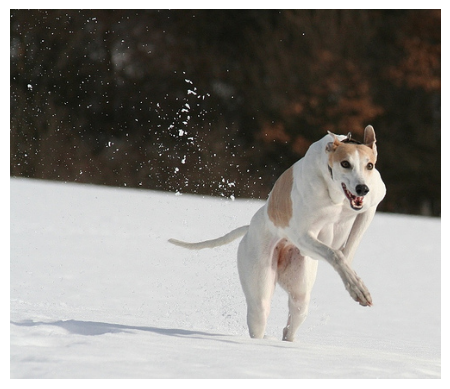

In [ ]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
data_path = "/content/drive/MyDrive/datasets/flickr8k"
df = pd.read_csv(f"{data_path}/captions.txt")

test_img_path = f"{data_path}/Images/" + df.iloc[50]["image"]
test_img = Image.open(test_img_path).convert("RGB")
plt.imshow(test_img)
plt.axis('off')
plt.show()

In [ ]:
generated_caption = generate_caption(test_img, model, feature_extractor, tokenizer)
print('\nGenerated Caption:', generated_caption)
print("True Caption:", df.iloc[50]["caption"])


Generated Caption: The small dog runs through a field .
True Caption: A brown and white dog is running through the snow .


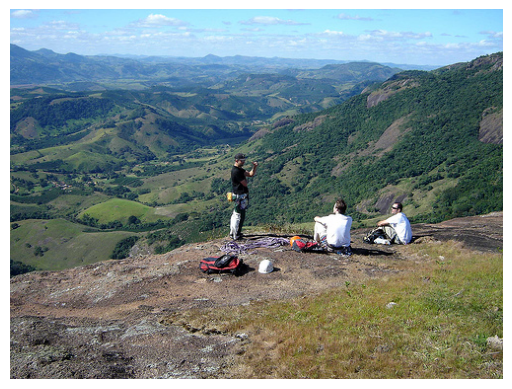

In [ ]:
test_img_path = f"{data_path}/Images/" + df.iloc[155]["image"]
test_img = Image.open(test_img_path).convert("RGB")
plt.imshow(test_img)
plt.axis('off')
plt.show()

In [ ]:
for temp in [1.6, 1.7, 1.8, 1.9]:
    caption = generate_caption(test_img, model, feature_extractor, tokenizer, temperature=temp)
    print(f"Generated Caption: {caption}")
print("True Caption:", df.iloc[155]["caption"])

Generated Caption: A person wearing a black t-shirt and sunglasses is sitting on a rock overlooking a valley .
Generated Caption: A group of people are standing around and waiting for the train to come down the road .
Generated Caption: a girl with hair pulled back sitting on a bench .
Generated Caption: The girl jumped in the air and hit the tree .
True Caption: People sit on the mountainside and check out the view .
